In [1]:
from fredapi import Fred
import yfinance as yf
import pandas_datareader.data as web

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import linregress
from itertools import product
from typing import List, Tuple, Dict
from datetime import timedelta


### Access Stock Information

In [2]:
### Current Tickers ###
mineral_stocks = [
    'GC=F',  # Gold
    'HG=F',  # Copper
    'PA=F',  # Palladium
    'PL=F',  # Platinum
    'SI=F',  # Silver
]


growth_stocks = [
    "NVDA",  # NVIDIA Corporation
    "MRVL",  # Marvell Technology Inc.
    "FTNT",  # Fortinet Inc.
    "AMD",   # Advanced Micro Devices, Inc.
    "CRM",   # Salesforce Inc.
    "ADBE",  # Adobe Inc.
    "ZM",    # Zoom Video Communications Inc.
    "SHOP",  # Shopify Inc.
    "SNAP",  # Snap Inc.
    "NET",   # Cloudflare, Inc.
    "TWLO",  # Twilio Inc.
    "MDB",   # MongoDB, Inc.
    "RBLX",  # Roblox Corporation
    "SNOW",  # Snowflake Inc.
    "PINS",  # Pinterest Inc.
    "TTD",   # The Trade Desk
    "DOCU",  # DocuSign, Inc.
    'SLAB',  # Silicon Laboratories Inc.
]

value_stocks = [
    "AAPL",  # Apple Inc.
    "MSFT",  # Microsoft Corporation
    "INTC",  # Intel Corporation
    "IBM",   # International Business Machines Corporation
    "ORCL",  # Oracle Corporation
    "CSCO",  # Cisco Systems, Inc.
    "HPE",   # Hewlett Packard Enterprise Co.
    "QCOM",  # Qualcomm Incorporated
    "TXN",   # Texas Instruments Incorporated
    "AVGO",  # Broadcom Inc.
    "MU",    # Micron Technology Inc.
    "LRCX",  # Lam Research Corporation
    "STX",   # Seagate Technology Holdings PLC
    "WDC",   # Western Digital Corporation
    "ADI",   # Analog Devices, Inc.
    "AMAT",  # Applied Materials, Inc.
    "MSI",   # Motorola Solutions, Inc.
    "VZ",    # Verizon Communications Inc.
    "TMUS"   # T-Mobile US, Inc.
]

market_indices = [
    "^DJI",     # Dow Jones Industrial Average (United States)
    "^GSPC",    # S&P 500 (United States)
    "^IXIC",    # NASDAQ Composite (United States)
    "^N225",    # Nikkei 225 (Japan)
    "^FTSE",    # FTSE 100 (United Kingdom)
    "^GDAXI",   # DAX (Germany)
    "^FCHI",    # CAC 40 (France)
    "000001.SS",# Shanghai Composite Index (China)
    "^BSESN",   # SENSEX (India)
    "^NSEI",    # Nifty 50 (India)
    "^KS11",    # KOSPI (South Korea)
    "^AORD",    # All Ordinaries (Australia)
    "^BVSP",    # Bovespa (Brazil)
    "^MERV",    # MERVAL (Argentina)
    "^TWII",    # TAIEX (Taiwan)
    "^STI",     # Straits Times Index (Singapore)
    "^JKSE",    # Jakarta Composite Index (Indonesia)   
]

non_sp500_stocks = [
    'BLBD',  # Blue Bird Corporation
    'LEGH',  # Legacy Housing Corporation
    'MVIS',  # MicroVision Inc.
    'HIMS',  # Hims & Hers Health, Inc.
    'VYGR',  # Voyager Therapeutics
    'ASTS',  # AST SpaceMobile, Inc.
    'JILL',  # J.Jill, Inc.
    'DCGO',  # DocGo Inc.
    'DNMR',  # Danimer Scientific
    'REKR',  # Rekor Systems, Inc.
    'KODK',  # Eastman Kodak Company
    'PRCH',  # Porch Group, Inc.
    'IMVT',  # Immunovant, Inc.
    'INDI',  # indie Semiconductor, Inc.
]


In [3]:
start_date = "2023-01-01"


### Download Mineral Data ###
minerals = yf.download(mineral_stocks,start=start_date,auto_adjust=True,progress=False)["Close"]
minerals = minerals.dropna()

## Download Closing Price of Growth and Value Stocks in One DataFrame ###
all_stocks = growth_stocks + value_stocks 
stock_data = yf.download(all_stocks, start=start_date, progress=False,auto_adjust=True)['Close']



5 Failed downloads:
['PA=F', 'PL=F', 'SI=F', 'GC=F', 'HG=F']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')

37 Failed downloads:
['CSCO', 'DOCU', 'TMUS', 'PINS', 'HPE', 'SNOW', 'STX', 'ZM', 'MRVL', 'AMD', 'TTD', 'NVDA', 'SLAB', 'AMAT', 'QCOM', 'NET', 'MU', 'ADI', 'MDB', 'VZ', 'INTC', 'AAPL', 'MSI', 'CRM', 'TWLO', 'LRCX', 'TXN', 'WDC', 'MSFT', 'FTNT', 'IBM', 'AVGO', 'RBLX', 'ORCL', 'ADBE', 'SNAP', 'SHOP']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


In [ ]:
### EFFECTIVE FEDERAL FUNDS RATE ###
api_key = "your api key"
fred = Fred(api_key=api_key)
# effr = fred.get_series(mineral_stocks,observation_start='2020-01-01')

# effr = pd.DataFrame(effr, columns = ['EFFR']).dropna()
# effr.reset_index(names='Date',inplace=True)

df = {}
for mineral in mineral_stocks:
    df[mineral] = fred.get_series(mineral)

df = pd.DataFrame(df)
df.plot()

ValueError: Bad Request.  Invalid value for variable series_id.  Series IDs should be 25 or less alphanumeric characters.

In [16]:
fred.get_series("GC=F")

ValueError: Bad Request.  Invalid value for variable series_id.  Series IDs should be 25 or less alphanumeric characters.

### Functions to generate trade signals and detect return under conditions

In [4]:
def generate_pairs(commodities_df:pd.DataFrame, stocks_df:pd.DataFrame, max_lag:int= 6) -> List[Tuple[pd.Series, pd.Series, int]]:
    """
    Generate all possible (commodity, stock, lag) combinations.
    
    Parameters:
        commodities_df: Input Dataframe of commodity closing prices with datetime index
        stocks_df: Input Dataframe of commodity closing prices with datetime index
        max_lag: Number of days for commodity lag 
    
    Returns:
        list: list of tuples of (commodity_series, stock_series) tuples
    """
    pairs = []
    for commodity, stock, lag in product(commodities_df.columns, stocks_df.columns, range(0,max_lag+1)):
        commodity_series = commodities_df[commodity]
        stock_series = stocks_df[stock]

        commodity_series.name = commodity
        stock_series.name = stock

        pairs.append((commodity_series,stock_series,lag))
    return pairs

def compute_features_for_pairs(pairs:List[Tuple[pd.Series,pd.Series]], rolling_window:int= 7, gradient:int= 5) -> Dict[str,pd.DataFrame]:
    """
    Compute features for multiple (commodity, stock) pairs. 
    
    Parameters:
        pairs: List of (commodity_series, stock_series) tuples
        rolling_window: Window size for rolling correlation
        gradient: Number of days for gradient computation 
    
    Returns:
        Dict[str, pd.DataFrame]: Dictionary with key=pair_name and value=feature_DataFrame
    """
    
    results = {}
    for commodity, stock, lag in pairs:
        commodity_name = f'{commodity.name}_lag_{str(lag)}'
        stock_name = stock.name
        pair_name = f"{commodity_name}_{stock_name}"
        
        commodity_returns =  np.log(commodity).diff(1+lag)
        stock_returns = np.log(stock).diff(1)
        
        
        df = pd.DataFrame(
            {'price': stock,
             commodity_name: commodity_returns,
            stock_name: stock_returns,
        }).dropna()
        
        df['rolling_corr'] = df[commodity_name].rolling(window=rolling_window).corr(df[stock_name])
        df['gradient'] = df[stock_name].rolling(window=gradient).apply(lambda x: linregress(range(gradient), x).slope, raw=True)

        results[pair_name] = df.dropna()
    return results


def rank_gradients_across_pairs(features_dict:Dict[str, pd.DataFrame]) -> pd.DataFrame:
    """
    Create a DataFrame where each column is the gradient of a pair
    Rank gradients across all pairs for each day.

    Returns:
        pd.DataFrame with dates as index and ranks as values (lower=stronger gradient)
    """
    gradients = []
    for pair_id, df in features_dict.items():
        gradient_series = df['gradient'].copy()
        gradient_series.name = pair_id
        gradients.append(gradient_series)
    
    all_gradients_df = pd.concat(gradients,axis=1).dropna().T.drop_duplicates().T
    ranked_gradients = all_gradients_df.abs().rank(axis=1,method='min',ascending=False)

    return ranked_gradients

def get_top_n_pairs_per_day(ranked_df:pd.DataFrame, n:int=10) -> pd.DataFrame:
    """
    Return top-N ranked pair IDs per day.
    
    Returns:
        pd.DataFrame with dates as index and top-N pair_ids as columns
    """
    return ranked_df.apply(lambda row: row.nsmallest(n).index.tolist(), axis=1).to_frame(name="top_pairs")


def detect_trade_signals(df,min_streak=3):
    """
    Operations:
        1. Identifies rolling correlation.
        2. Identifies streaks of outlier rolling correlations. - higher and lower quartiles
        3. Filters for top 50% absolute gradient values.
        4. Calucluates trade signals based on sign of the gradient.
    
    Parameters:
        df: Input Dataframe of commodity closing prices with datetime index
        thershold: int - threshold of rolling correlation
        min_streak: int - minimum number of consecutive days of correlations above threshold
    
    Returns:
        pd.DataFrame: dataframe with rolling_corr, gradient, and trade_signal
    """
    rolling_corr_quantiles = np.round(df.rolling_corr.quantile([.025,.975]).values,5)
    low_rolling_corr = min(-0.6,rolling_corr_quantiles[0])
    high_rolling_corr = max(0.6,rolling_corr_quantiles[1])
   
    
    df['over_thresh'] = df['rolling_corr'].apply(lambda x: 1 if x > high_rolling_corr or x < low_rolling_corr  else 0)  
    # Create a streak column that only counts consecutive days above/below thresholds
    df['streak'] = (
        df['over_thresh']
        .groupby(df['over_thresh'].ne(df['over_thresh'].shift()).cumsum())
        .cumcount() + 1
    ) * df['over_thresh']           # set to 0 when not over threshold

    # Filter for streaks that meet min_streak requirement
    gradient_quantiles = np.round(df[(df['streak']>=min_streak)]['gradient'].quantile([0.25,0.75]).values,5)
    low_gradient = gradient_quantiles[0]
    high_gradient = gradient_quantiles[1]
    
    df['signal'] = df.apply(
        lambda row: 1 if row['gradient'] > high_gradient and row['rolling_corr'] > high_rolling_corr and row['streak'] >= min_streak
        else (-1 if row['gradient'] < low_gradient and row['rolling_corr'] < low_rolling_corr and row['streak'] >= min_streak else 0),
        axis=1
    )

    return df

def n_day_return(signals, stocks):
    """
    Calcualates returns for buy and sells under a condition

        currently set to hold for (average_lag + streak)
        if buy signal, calculates return for buy
        if sell signal, calculates return for short
    
    Returns:
        List of Returns
    """
    # Make sure the index of stock_prices is datetime
    stock_data.index = pd.to_datetime(stock_data.index)
    # Create a list to store percent changes
    percent_changes = []

    average_streaks = signals[(signals.signal!=0)].groupby('pair')['streak'].mean().astype(int)
    ## Iterate through signals and stock data to calculate n day return from signal day
    for idx, row in signals.iterrows():
        if row['signal'] != 0:
            pair = row['pair'] # grab pair
            stock = row['stock_name'] # Grab stock name
            signal_date = idx.date().strftime("%Y-%m-%d")  # Grab date
            price_on_signal_day = row['price'] # Grab price on signal date
            
            hold_period = average_streaks[pair]   ## Holding for average streak + lag
            
            pos = stock_data.index.get_loc(signal_date)
            
            
            
            if pos + 3 < len(stock_data):
                price_n_days_later = stock_data.iloc[pos + hold_period][stock]
                if row['signal'] == 1:
                    percent_change = (price_n_days_later - price_on_signal_day) / price_on_signal_day
                elif row['signal'] == -1:
                    percent_change = (price_on_signal_day - price_n_days_later) / price_on_signal_day
                percent_changes.append(percent_change)
        else:
            percent_changes.append(None)

    return percent_changes

def detect_signals_from_top_pairs(top_3_per_day:pd.DataFrame, features:dict, min_streak:int = 3) -> pd.DataFrame:
    """
    Detect trade signals using top N ranked pairs per day and full signal logic.
    
    Parameters:
        top_3_per_day (pd.DataFrame): DataFrame with 'date' and 'pair' columns.
        features (dict): Dictionary of computed feature DataFrames for each pair.
        min_streak (int): Minimum streak length to trigger signal logic.

    Returns:
        pd.DataFrame: Signal DataFrame with date, pair, signal, gradient, rolling_corr, etc.
    """
    signal_rows = []
    for date, row in top_3_per_day.iterrows():
        for pair in row['top_pairs']:
            if pair not in features:
                continue

            feature_df = features[pair].copy()
            features_with_signals = detect_trade_signals(feature_df,min_streak=min_streak)

            if date in features_with_signals.index:
                signal_row = features_with_signals.loc[[date]].copy()
                signal_row['pair'] = pair
                signal_rows.append(signal_row[['pair','price','gradient','rolling_corr', 'signal','streak']])
    
    result_df = pd.concat(signal_rows).sort_index()
    result_df['lag'] = result_df['pair'].str.extract(r'lag_(\d+)').astype(int)
    result_df['stock_name'] = result_df['pair'].str.split('_').str[-1]

    result_df['n_day_return'] = n_day_return(result_df,stock_data)
    return result_df

### Generate Features and Signals

In [5]:
pairs = generate_pairs(commodities_df=minerals, stocks_df=stock_data, max_lag=5)
features = compute_features_for_pairs(pairs,rolling_window=10, gradient=2)
rankings = rank_gradients_across_pairs(features)
top_n_per_day = get_top_n_pairs_per_day(rankings, n=10)
signals = detect_signals_from_top_pairs(top_n_per_day,features,min_streak=3)

ValueError: No objects to concatenate

In [513]:
print(f"Total Return Under Conditions: {signals[signals.signal!=0].n_day_return.sum()*100:.4g}%")

signals[signals.signal!=0]


Total Return Under Conditions: 45.2%


,pair,price,gradient,rolling_corr,signal,streak,lag,stock_name,n_day_return
Date,,,,,,,,,
2023-02-24,GC=F_lag_0_SHOP,40.750000,-0.047514,-0.640232,-1,3,0,SHOP,-0.010552
2023-05-09,GC=F_lag_0_NVDA,28.552456,-0.036386,-0.868536,-1,3,0,NVDA,0.008085
2023-05-26,GC=F_lag_0_AMD,127.029999,-0.051757,-0.600272,-1,5,0,AMD,0.071637
2023-05-30,GC=F_lag_0_AMD,125.269997,-0.067971,-0.665690,-1,6,0,AMD,0.008302
2023-06-05,GC=F_lag_0_TMUS,129.299316,0.065000,0.827276,1,4,0,TMUS,-0.006504
2023-07-28,GC=F_lag_0_PINS,28.450001,0.088304,0.772136,1,4,0,PINS,-0.045343
2023-08-18,GC=F_lag_0_NET,58.980000,0.054063,0.798688,1,4,0,NET,0.070024
2023-08-23,GC=F_lag_0_INTC,33.421032,0.040176,0.768269,1,5,0,INTC,0.009712
2023-08-29,GC=F_lag_0_SHOP,58.799999,0.029501,0.902792,1,5,0,SHOP,0.119048


### Run Backtest

* under maintenance

In [397]:
import backtester
import importlib
importlib.reload(backtester)
from backtester import Backtester
from backtester import Strategy


Final Portfolio Value: 1621.62
Total Return: -83.78%
Annualized Return: -56.48%
Annualized Volatility: 52.80%
Sharpe Ratio: -1.11
Sortino Ratio: -0.84
Maximum Drawdown: -25.98%


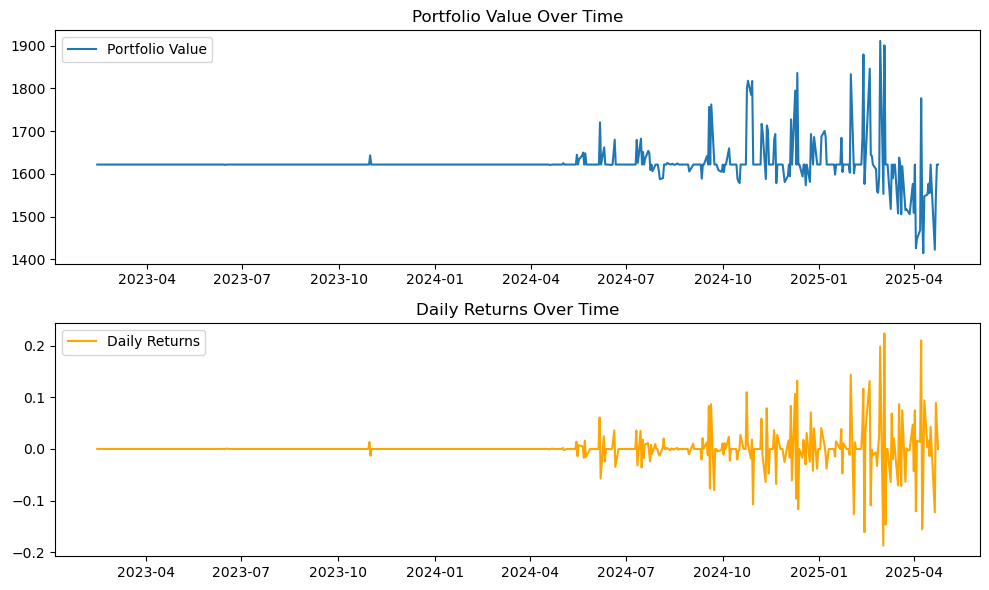

In [398]:
data = signals[['pair','price','signal']].dropna()
backtester = Backtester()
backtester.backtest(data)
backtester.calculate_performance()